# GBGPU Tutorial

`GBGPU` is a GPU-accelerated version of the `FastGB` waveform which has been developed by Neil Cornish, Tyson Littenberg, Travis Robson, and Stas Babak. It computes gravitational waveforms for Galactic binary systems observable by LISA using a fast/slow-type decomposition. For more details on the original construction of `FastGB` see [arXiv:0704.1808](https://arxiv.org/abs/0704.1808).

The current version of the code is very closely related to the implementation of `FastGB` in the LISA Data Challenges' Python code package. The waveform code is entirely Python-based. It is about 1/2 the speed of the full C version, but much simpler in Python for right now. There are also many additional functions including fast likelihood computations for individual Galactic binaries, as well as fast C-based methods to combine waveforms into global fitting templates. 

The code is CPU/GPU agnostic. CUDA and NVIDIA GPUs are required to run these codes for GPUs.

See the [documentation](https://mikekatz04.github.io/GBGPU/html/index.html) for more details. This code was designed for (# TODO: add new arxiv number). If you use any part of this code, please cite (# TODO: add new arxiv number), its Zenodo page (# TODO: add zenodo page), [arXiv:0704.1808](https://arxiv.org/abs/0704.1808), and [arXiv:1806.00500](https://arxiv.org/abs/1806.00500). 

In [1]:
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

from gbgpu.gbgpu import GBGPU

from gbgpu.utils.constants import *

## Generated Galactic binary waveforms

Initialize the waveform class.

In [2]:
gb = GBGPU(use_gpu=False)

Setup all the binary information. GBGPU operates in a vectorized manner, so it takes arrays of parameters as inputs.

In [3]:
dt = 10.0
Tobs = 4.0 * YEAR


# number of points in waveform
# if None, will determine inside the code based on amp, f0 (and P2 if running third-body waveform)
N = None

# number of binaries to batch
num_bin = 10

# parameters
amp = 2e-23  # amplitude
f0 = 2e-3  # f0
fdot = 7.538331e-18  # fdot
fddot = 0.0 # fddot
phi0 = 0.1  # initial phase
iota = 0.2  # inclination
psi = 0.3  # polarization angle
lam = 0.4  # ecliptic longitude
beta_sky = 0.5  # ecliptic latitude


# for batching
amp_in = np.full(num_bin, amp)
f0_in = np.full(num_bin, f0)
fdot_in = np.full(num_bin, fdot)
fddot_in = np.full(num_bin, fddot)
phi0_in = np.full(num_bin, phi0)
iota_in = np.full(num_bin, iota)
psi_in = np.full(num_bin, psi)
lam_in = np.full(num_bin, lam)
beta_sky_in = np.full(num_bin, beta_sky)


Generate the waveforms.

signal length: (512,)


(0.0019993, 0.0020007000000000002)

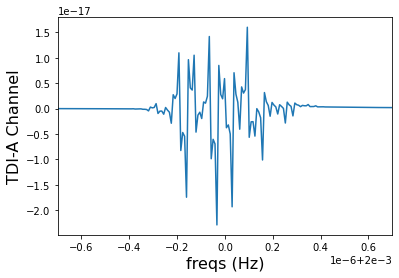

In [4]:
%matplotlib  inline
params = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

gb.run_wave(*params, N=N, dt=dt, T=Tobs, oversample=2)

# signal from first binary
A = gb.A[0]
freqs = gb.freqs[0]
print("signal length:", A.shape)
plt.plot(freqs, A.real)
plt.ylabel("TDI-A Channel", fontsize=16)
plt.xlabel("freqs (Hz)", fontsize=16)
dx = 7e-7
plt.xlim(f0 - dx, f0 + dx)

### Add a third-body

In [5]:
A2 = 100.0  # third body amplitude parameter
varpi = 1.0  # varpi phase parameter
e2 = 0.3  # eccentricity of third body
P2 = 1.2  # period of third body
T2 = 0.5 * P2  # time of periapsis passage of third body


A2_in = np.full(num_bin, A2)
P2_in = np.full(num_bin, P2)
varpi_in = np.full(num_bin, varpi)
e2_in = np.full(num_bin, e2)
T2_in = np.full(num_bin, T2)

Third-body signal length: (512,)


(0.0019993, 0.0020007000000000002)

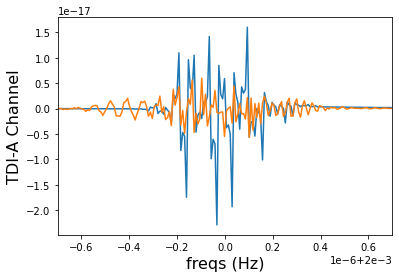

In [6]:
%matplotlib  inline
params = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in, A2_in, varpi_in, e2_in, P2_in, T2_in]
)

gb.run_wave(*params, N=N, dt=dt, T=Tobs, oversample=2)

# signal from first binary
A_third = gb.A[0]
freqs = gb.freqs[0]
print("Third-body signal length:", A_third.shape)
plt.plot(freqs, A.real, label="No third body")
plt.plot(freqs, A_third.real, label="No third body")
plt.ylabel("TDI-A Channel", fontsize=16)
plt.xlabel("freqs (Hz)", fontsize=16)
dx = 7e-7
plt.xlim(f0 - dx, f0 + dx)

## Calculating the Information Matrix

In [7]:
params = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

inds = np.array([0, 1, 2, 4, 5, 6, 7, 8])

info_matrix = gb.information_matrix(
    params,
    easy_central_difference=False,
    eps=1e-9,
    inds=inds,
    N=1024,
    dt=dt,
    T=Tobs,
)

cov = np.linalg.pinv(info_matrix)

cov.shape

(10, 8, 8)

Covariance Matrix for first binary:

In [8]:
cov[0]

array([[ 2.59077356e-03, -1.73881105e-11,  5.79303854e-06,
        -9.34813784e-06, -1.04002859e-04, -5.60750479e-05,
         1.67605334e-05,  9.25171196e-05],
       [-1.73881104e-11,  1.22082662e-14,  1.64237500e-09,
        -2.54833541e-09,  1.37966733e-13, -1.52900681e-08,
         5.16215869e-10, -3.66331834e-10],
       [ 5.79303858e-06,  1.64237500e-09,  3.24595981e-04,
        -5.03938709e-04, -3.47043395e-07, -3.02364387e-03,
         1.81105534e-05,  1.29976949e-04],
       [-9.34813786e-06, -2.54833541e-09, -5.03938709e-04,
         7.82376988e-04,  5.53048679e-07,  4.69427999e-03,
        -2.96655655e-05, -2.05333283e-04],
       [-1.04002859e-04,  1.37967094e-13, -3.47043323e-07,
         5.53048569e-07,  4.17508525e-06,  3.31774245e-06,
        -6.68420959e-07, -3.78390944e-06],
       [-5.60750482e-05, -1.52900681e-08, -3.02364387e-03,
         4.69427999e-03,  3.31774311e-06,  2.81657883e-02,
        -1.78010037e-04, -1.23202090e-03],
       [ 1.67605334e-05,  5.162158

Standard deviation on the marginalized parameters:

In [9]:
params[inds, 0] * cov[0].diagonal() ** (1/2)

array([1.01799284e-24, 2.20982046e-10, 1.35814698e-19, 2.79710026e-03,
       4.08660507e-04, 5.03479985e-02, 1.57517708e-02, 2.25836812e-02])

Plot the Information Matrix ellipse for the intial frequency and frequency derivative:

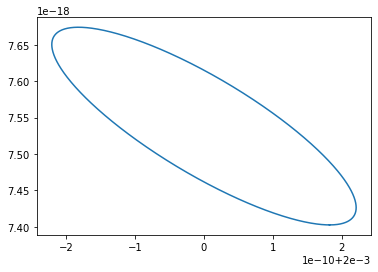

In [11]:


ind1 = 1 
ind2 = 2
inds_get = np.array([
    [ind1, ind1],
    [ind1, ind2],
    [ind2, ind1],
    [ind2, ind2]
]).T
sub_mat = cov[0][tuple(inds_get)].reshape(2, 2)

# calculate and draw covariance ellipse
a, b, b, c = sub_mat.flatten()

lam1 = (a + c) / 2. + np.sqrt(((a-c)/2) ** 2 + b ** 2)
lam2 = (a + c) / 2. - np.sqrt(((a-c)/2) ** 2 + b ** 2)

if b == 0. and a >= c:
    theta = 0.0
elif b == 0. and a < c:
    theta = np.pi / 2.
else:
    theta = -np.arctan2(lam1 - a, b)

t_vals = np.linspace(0., 2 * np.pi, 1000)
x = np.sqrt(lam1) * np.cos(theta) * np.cos(t_vals) - np.sqrt(lam2) * np.sin(theta) * np.sin(t_vals)
y = np.sqrt(lam1) * np.sin(theta) * np.cos(t_vals) + np.sqrt(lam2) * np.cos(theta) * np.sin(t_vals)

x_in = params[1, 0] * (1 + x)
y_in = params[2, 0] * (1 + y)
plt.plot(x_in, y_in)